# Summary Statistics
Exploring the NYC Building Elevation and Subgrade (BES) Data Set in Python

Author: Mark Bauer

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, HTML
import duckdb

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

In [3]:
# Printing verions of Python modules and packages with **watermark** - the IPython magic extension.
%reload_ext watermark
%watermark -v -p numpy,pandas,matplotlib,seaborn,duckdb

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

numpy     : 1.23.1
pandas    : 1.4.3
matplotlib: 3.5.2
seaborn   : 0.11.2
duckdb    : 0.10.0



![cover-photo](images/dataset-cover-photo.png)
Screenshot of data set on NYC Open Data.

Link to data set website: https://data.cityofnewyork.us/City-Government/Building-Elevation-and-Subgrade-BES-/bsin-59hv

In [4]:
# create a DuckDB database instance
con = duckdb.connect()

# examine count of rows
con.sql("SELECT COUNT(*) AS count_rows FROM read_parquet('data/bes-data.parquet')").show()

┌────────────┐
│ count_rows │
│   int64    │
├────────────┤
│     861876 │
└────────────┘



In [5]:
# convert duckdb table to a dataframe
df = con.sql("SELECT * FROM read_parquet('data/bes-data.parquet')").df()

rows, cols = df.shape
print('rows: {:,}\ncolumns: {}'.format(rows, cols))

# preview data
df.head()

rows: 861,876
columns: 26


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


# Examining Building Elevation Measurements

`z_grade`: The elevation of the building at it's lowest adjacent grade - the lowest point where the building touches the ground.

`z_floor`: The elevation of what is estimated to be the lowest actively used floor.

Definitions from the data dictionary.

In [6]:
# summary statistics
(df
 .loc[:, ['z_grade', 'z_floor']]
 .describe()
)

,z_grade,z_floor
count,861876.000000,861876.000000
mean,53.915012,58.113704
std,42.192895,42.560673
min,-13.096000,0.000000
25%,23.304000,27.438000
50%,44.328000,48.370000
75%,72.709250,77.063000
max,402.839000,404.397000


Check for values below zero.

In [7]:
counts = (
    df
    .loc[df['z_grade'] < 0]
    .shape[0]
)

print('count of properties where z_grade value < 0: {:,}'.format(counts))

count of properties where z_grade value < 0: 11


In [8]:
counts = (
    df
    .loc[df['z_floor'] < 0]
    .shape[0]
)

print('count of properties where z_floor value < 0: {:,}'.format(counts))

count of properties where z_floor value < 0: 0


Check for values equal to zero.

In [9]:
counts = (
    df
    .loc[df['z_grade'] == 0]
    .shape[0]
)

print('count of properties where z_grade is 0 (no measurement): {:,}'.format(counts))

count of properties where z_grade is 0 (no measurement): 14,039


In [10]:
counts = (
    df
    .loc[df['z_floor'] == 0]
    .shape[0]
)

print('count of properties where z_floor is 0 (no measurement): {:,}'.format(counts))

count of properties where z_floor is 0 (no measurement): 14,038


Interesting that there is one building that doesn't reconcile. Let's examine the measurement notes.

In [11]:
bin_id = (
    df
    .loc[(df['z_grade'] == 0) & (df['z_floor'] != 0), 'bin']
    .values[0]
)

df.loc[df['bin'] == bin_id, ['bin', 'z_grade', 'z_floor', 'notes1']]

,bin,z_grade,z_floor,notes1
293514,3109155,0.0,42.929,Property was Successfully Measured


We can leave this record in for now even with the presense of zero, but it might be worth examining in the future. The notes1 confirms that this property was successfully measured. 

Let's drop all records where `z_floor` is zero.

In [12]:
# sanity check before dropping z_floor is zero
(df
 .loc[df['z_floor'] == 0, 'notes1']
 .value_counts()
 .reset_index()
 .rename(columns={'index':'notes1', 'notes1':'count'})
)

,notes1,count
0,Property not Visible from Street; No Address P...,12079
1,Vacant Lot; No Address Plate or Identification...,1957
2,Property not Visible from Street; No Address P...,1
3,Property not Visible Due to Construction or Ob...,1


In [13]:
# drop all records where z_floor is zero
df = (
    df
    .loc[df['z_floor'] != 0]
    .reset_index(drop=True)
)

print('new shape of data:', df.shape)
df.head()

new shape of data: (847838, 26)


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,longitude,pluto_bbl,Council,BoroCD,CTLabel,BoroCT2020,NTA2020,NTAName,CDTA2020,CDTAName
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,-74.222746,5075340353,51,503,226.01,5022601,SI0304,Annadale-Huguenot-Prince's Bay-Woodrow,SI03,SI03 South Shore (CD 3 Approximation)
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,-74.241793,5075960125,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,-74.241090,5075960131,51,503,226.02,5022602,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,-74.246496,5079150042,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,-74.241980,5078680123,51,503,244.01,5024401,SI0305,Tottenville-Charleston,SI03,SI03 South Shore (CD 3 Approximation)


In [22]:
# sanity check before dropping z_floor is zero
(df
 .loc[:, ['notes1']]
 .value_counts()
)

notes1                                                                                                                              
Property was Successfully Measured                                                                                                      646782
Property not Visible Due to Construction or Obstruction                                                                                 115280
Property was Successfully Measured; No Address Plate or Identification on Building                                                       61567
Property not Visible Due to Construction or Obstruction; No Address Plate or Identification on Building                                  17132
Property was Successfully Measured; Property Under Construction                                                                           2946
Property not Visible Due to Construction or Obstruction; No Address Plate or Identification on Building; Property Under Construction      1676
Property 

In [23]:
# summary statistics
(df
 .loc[:, ['z_grade', 'z_floor']]
 .describe()
)

,z_grade,z_floor
count,847838.000000,847838.000000
mean,54.807705,59.075916
std,41.961769,42.244047
min,-13.096000,0.703000
25%,24.227250,28.361000
50%,45.095000,49.224000
75%,73.342750,77.704750
max,402.839000,404.397000


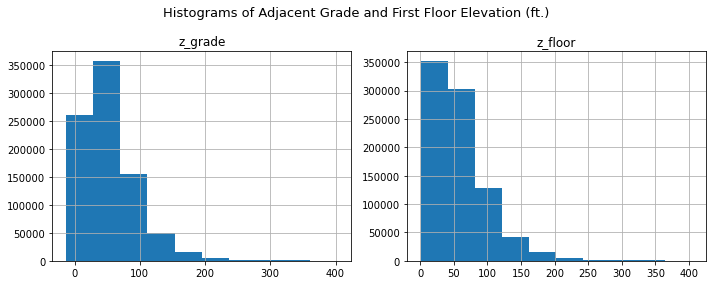

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

(df
 .loc[:, ['z_grade', 'z_floor']]
 .hist(ax=ax)
)

plt.suptitle('Histograms of Adjacent Grade and First Floor Elevation (ft.)', fontsize=13)
plt.tight_layout()

**Figure xx:** Histograms of z_grade and z_floor values (ft.).

Caption this for later.

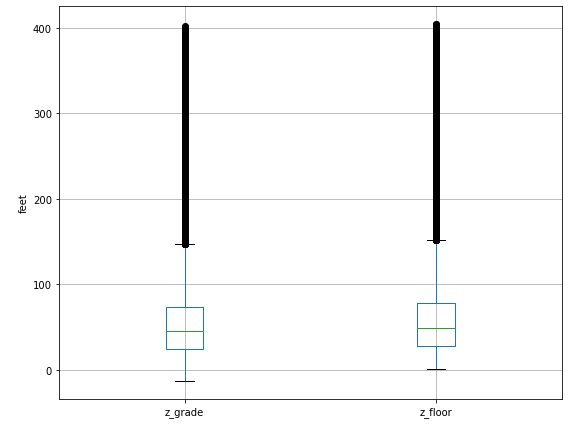

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

df.boxplot(column=['z_grade', 'z_floor'])

plt.ylabel('\nfeet')
plt.tight_layout()

**Figure xx:** Boxplots of z_grade and z_floor values (ft.).

Caption this for later.

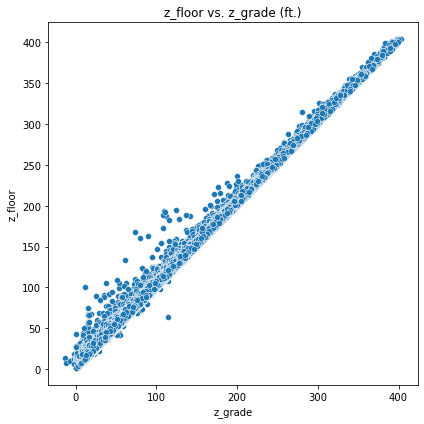

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.scatterplot(
    x=df['z_grade'],
    y=df['z_floor'],
    ax=ax
)

plt.title('z_floor vs. z_grade (ft.)')
plt.tight_layout()

**Figure xx:** Histograms of z_grade and z_floor values (ft.).

Caption this for later.

In [28]:
(df
 .loc[
     (df['z_grade'] > 100)
     & (df['z_floor'] < 70)]
 .iloc[:, :-9]
)

,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,notes1,notes2,notes3,x,y,latitude,longitude
581783,POINT (-73.90546567085973 40.708900200415925),4434111,4033730056,4.0,3373.0,56,2115 GROVE STREET,113.93,63.443,N,Property was Successfully Measured; No Address...,"Commercial, Industrial or other Non-Residentia...",None,1.010459e+06,197562.090818,40.7089,-73.905466


More review is required, but this might be a measurement error. We can leave this in for now.

Examine `z_grade` > `z_floor`.

In [29]:
counts = (
    df
    .loc[df['z_floor'] < df['z_grade']]
    .shape[0]
)

print('count of properties where z_floor is less than z_grade and z_floor is not zero: {:,}'.format(counts))

count of properties where z_floor is less than z_grade and z_floor is not zero: 316


Looks like there are 316 properties that seem to not be considered a first *occupied* floor. Let's check the notes.

In [30]:
# examine scenario
(df
 .loc[df['z_grade'] > df['z_floor'], ['notes1']]
 .value_counts()
)

notes1                                                                                                                              
Property was Successfully Measured                                                                                                      246
Property was Successfully Measured; No Address Plate or Identification on Building                                                       34
Property not Visible Due to Construction or Obstruction                                                                                  13
Property not Visible Due to Construction or Obstruction; No Address Plate or Identification on Building                                  10
Property not Visible Due to Construction or Obstruction; No Address Plate or Identification on Building; Property Under Construction      5
Property not Visible Due to Construction or Obstruction; Property Under Construction                                                      3
Property was Successfully M

We can leave these in, but they might not be considered a first *occupied* floor.

## Calculating First Floor Height from Lowest Adjacent Grade to First Floor Elevation

In [38]:
# height from building floor to grade
df['first_floor_height'] = df['z_floor'] - df['z_grade']

# summary stats
df['first_floor_height'].describe()

count    847838.000000
mean          4.268211
std           3.087679
min         -50.487000
25%           2.015000
50%           3.627000
75%           6.571000
max          94.440000
Name: first_floor_height, dtype: float64

In [39]:
mean = df['first_floor_height'].mean()

print('mean value of FFH from lowest adjacent grade to first floor elevation: {:.2f} ft.'.format(mean))

mean value of FFH from lowest adjacent grade to first floor elevation: 4.27 ft.


In [40]:
median = df['first_floor_height'].median()

print('median value of FFE from lowest adjacent grade to first floor elevation: {:.2f} ft.'.format(median))

median value of FFE from lowest adjacent grade to first floor elevation: 3.63 ft.


In [41]:
# average of average neighborhood grade to floor height
mean_nta = (
    df
    .groupby(by=['NTAName'])['first_floor_height']
    .mean()
    .mean()
)

print('mean value of mean NTA height from lowest adjacent grade to lowest floor elevation: {:.2f} ft.'.format(mean_nta))

mean value of mean NTA height from lowest adjacent grade to lowest floor elevation: 3.82 ft.


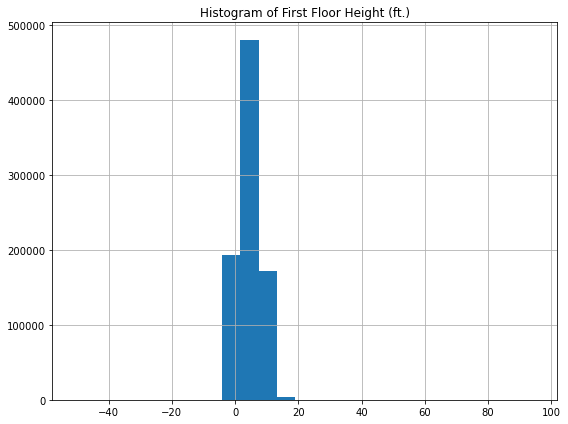

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))

df['first_floor_height'].hist(ax=ax, bins=25)

plt.title('Histogram of First Floor Height (ft.)')
plt.tight_layout()

**Figure xx:** Histogram of building adjacent grade to first floor elevation (ft.).

Caption this for later.

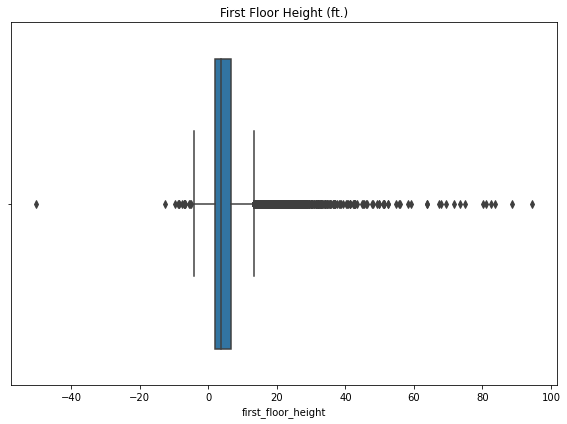

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(x=df["first_floor_height"], ax=ax)

plt.title('First Floor Height (ft.)')
plt.tight_layout()

# Adding Borough Column
It's useful to have a full Neighborhood Tabulation Areas (NTA) and Borough column.

In [46]:
# reading in NTA shape, only being used as a df and not gdf
url = 'https://data.cityofnewyork.us/api/geospatial/9nt8-h7nd?accessType=DOWNLOAD&method=export&format=Shapefile'
nta_df = gpd.read_file(url)

print('shape of data: {}'.format(nta_df.shape))
nta_df.head()

shape of data: (262, 12)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry
0,3.0,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.566468,3.532121e+07,"POLYGON ((-73.93213 40.72816, -73.93238 40.727..."
1,3.0,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026671,2.885431e+07,"POLYGON ((-73.95814 40.72440, -73.95772 40.724..."
2,3.0,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.279986,1.520896e+07,"POLYGON ((-73.95024 40.70547, -73.94984 40.705..."
3,3.0,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.772485,5.226621e+07,"POLYGON ((-73.92406 40.71411, -73.92404 40.714..."
4,3.0,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.504358,9.982322e+06,"POLYGON ((-73.99236 40.68969, -73.99436 40.690..."


In [47]:
# reading in NTA shape
url = 'https://data.cityofnewyork.us/api/geospatial/9nt8-h7nd?accessType=DOWNLOAD&method=export&format=Shapefile'
gdf = gpd.read_file(url)

# convert crs to 2263
gdf = gdf.to_crs(2263)

gdf['ntaname_boro'] = gdf['ntaname'] + ', ' + gdf['boroname']

print('shape of data:', gdf.shape)
gdf.head()

shape of data: (262, 13)


,borocode,boroname,countyfips,nta2020,ntaname,ntaabbrev,ntatype,cdta2020,cdtaname,shape_leng,shape_area,geometry,ntaname_boro
0,3.0,Brooklyn,047,BK0101,Greenpoint,Grnpt,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28912.566468,3.532121e+07,"POLYGON ((1003059.997 204572.025, 1002991.367 ...","Greenpoint, Brooklyn"
1,3.0,Brooklyn,047,BK0102,Williamsburg,Wllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),28098.026671,2.885431e+07,"POLYGON ((995851.916 203199.332, 995969.193 20...","Williamsburg, Brooklyn"
2,3.0,Brooklyn,047,BK0103,South Williamsburg,SWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),18250.279986,1.520896e+07,"POLYGON ((998047.210 196303.325, 998157.901 19...","South Williamsburg, Brooklyn"
3,3.0,Brooklyn,047,BK0104,East Williamsburg,EWllmsbrg,0,BK01,BK01 Williamsburg-Greenpoint (CD 1 Equivalent),43184.772485,5.226621e+07,"POLYGON ((1005302.497 199455.730, 1005307.792 ...","East Williamsburg, Brooklyn"
4,3.0,Brooklyn,047,BK0201,Brooklyn Heights,BkHts,0,BK02,BK02 Downtown Brooklyn-Fort Greene (CD 2 Appro...,14312.504358,9.982322e+06,"POLYGON ((986367.736 190549.239, 985813.836 19...","Brooklyn Heights, Brooklyn"


In [48]:
# merge and retrieve nta and boro name data
nta_df = nta_df.loc[:, ['nta2020', 'boroname']]

df = df.merge(
    nta_df,
    left_on='NTA2020',
    right_on='nta2020',
    how='left'
)

df['ntaname_boro'] = df['NTAName'] + ', ' + df['boroname']

print('shape of data: {}'.format(df.shape))
df.head()

shape of data: (847838, 34)


,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,CDTA2020,CDTAName,first_floor_height,nta2020_x,boroname_x,ntaname_boro,nta2020_y,boroname_y,nta2020,boroname
0,POINT (-74.22274561187417 40.52134422844183),5128004,5075340353,5.0,7534.0,353,78 SAVO LOOP,29.428,32.332,N,...,SI03,SI03 South Shore (CD 3 Approximation),2.904,SI0304,Staten Island,"Annadale-Huguenot-Prince's Bay-Woodrow, Staten...",SI0304,Staten Island,SI0304,Staten Island
1,POINT (-74.24179250549321 40.52875316810818),5155392,5075960125,5.0,7596.0,125,72 CHART LOOP,25.366,26.703,N,...,SI03,SI03 South Shore (CD 3 Approximation),1.337,SI0305,Staten Island,"Tottenville-Charleston, Staten Island",SI0305,Staten Island,SI0305,Staten Island
2,POINT (-74.24109012652094 40.528883822921635),5148808,5075960131,5.0,7596.0,131,40 TIDES LANE,36.172,38.902,N,...,SI03,SI03 South Shore (CD 3 Approximation),2.730,SI0305,Staten Island,"Tottenville-Charleston, Staten Island",SI0305,Staten Island,SI0305,Staten Island
3,POINT (-74.24649640323727 40.507045708438184),5088274,5079150042,5.0,7915.0,42,328 MAIN STREET,69.897,72.459,N,...,SI03,SI03 South Shore (CD 3 Approximation),2.562,SI0305,Staten Island,"Tottenville-Charleston, Staten Island",SI0305,Staten Island,SI0305,Staten Island
4,POINT (-74.24198032271697 40.51005666426356),5087850,5078680123,5.0,7868.0,123,309 SLEIGHT AVENUE,74.907,79.122,N,...,SI03,SI03 South Shore (CD 3 Approximation),4.215,SI0305,Staten Island,"Tottenville-Charleston, Staten Island",SI0305,Staten Island,SI0305,Staten Island


Examine outlier.

In [49]:
df.loc[df['first_floor_height'] < -40]

,the_geom,bin,bbl,borough,block,lot,address,z_grade,z_floor,subgrade,...,CDTA2020,CDTAName,first_floor_height,nta2020_x,boroname_x,ntaname_boro,nta2020_y,boroname_y,nta2020,boroname
581783,POINT (-73.90546567085973 40.708900200415925),4434111,4033730056,4.0,3373.0,56,2115 GROVE STREET,113.93,63.443,N,...,QN05,QN05 Ridgewood-Maspeth-Middle Village (CD 5 Ap...,-50.487,QN0502,Queens,"Ridgewood, Queens",QN0502,Queens,QN0502,Queens


Same outlier building as the previous inquiry. We can leave in for now, but probably good to examine further at some point.

In [50]:
# total counts by NTA
nta_counts = (
    df
    .groupby(by=['nta2020'])['bin']
    .count()
    .rename('count')
    .reset_index()
)

# counts that were measured successfully by NTA
nta_counts_measured = (
    df
    .loc[df['notes1'] == 'Property was Successfully Measured']
    .groupby(by=['ntaname_boro', 'nta2020'])['bin']
    .count()
    .rename('count_measured')
    .reset_index()
)

# merge both counts and count measured dataframes
nta_counts_merged = nta_counts.merge(
    nta_counts_measured,
    on='nta2020',
    how='left'
)

# examine data
print('shape of data: {}'.format(nta_counts_measured.shape))
nta_counts_merged.head()

shape of data: (237, 3)


,nta2020,count,ntaname_boro,count_measured
0,BK0101,4815,"Greenpoint, Brooklyn",2886.0
1,BK0102,3387,"Williamsburg, Brooklyn",2339.0
2,BK0103,2057,"South Williamsburg, Brooklyn",1161.0
3,BK0104,4422,"East Williamsburg, Brooklyn",3089.0
4,BK0201,1432,"Brooklyn Heights, Brooklyn",553.0


In [51]:
# Stuyvesant Town-Peter Cooper Village, Manhattan - MN0601
# Fort Hamilton, Brooklyn - BK1061

nta_exclude = (
    nta_counts_merged
    .loc[(nta_counts_merged['count'] < 300)
            & (~nta_counts_merged['nta2020'].isin(['MN0601', 'BK1061'])),
         'nta2020']
    .values
)

nta_exclude

array(['BK0261', 'BK0471', 'BK0571', 'BK0771', 'BK0891', 'BK1091',
       'BK1771', 'BK1891', 'BK1892', 'BK1893', 'BK5591', 'BK5691',
       'BK5693', 'BX0391', 'BX0491', 'BX0492', 'BX0991', 'BX1091',
       'BX1161', 'BX1271', 'BX2691', 'BX2791', 'BX2891', 'MN0191',
       'MN1191', 'MN1291', 'MN1292', 'MN6491', 'QN0161', 'QN0171',
       'QN0191', 'QN0261', 'QN0271', 'QN0571', 'QN0572', 'QN0573',
       'QN0574', 'QN0761', 'QN0791', 'QN0871', 'QN0891', 'QN1191',
       'QN1371', 'QN1491', 'QN8081', 'QN8191', 'QN8291', 'QN8381',
       'QN8491', 'QN8492', 'SI0191', 'SI0291', 'SI0391', 'SI9561',
       'SI9592', 'SI9593'], dtype=object)

In [52]:
# mean grade to floor height by NTA
nta_mean = (
    df
    .groupby(by='ntaname_boro')['first_floor_height']
    .describe()
    .reset_index()
)

# preview count measured dataframe
nta_mean.head()

,ntaname_boro,count,mean,std,min,25%,50%,75%,max
0,"Allerton, Bronx",1648.0,5.098075,3.770589,0.010,1.01925,5.0685,8.530,18.505
1,"Alley Pond Park, Queens",2.0,2.664000,3.176324,0.418,1.54100,2.6640,3.787,4.910
2,"Annadale-Huguenot-Prince's Bay-Woodrow, Staten...",11167.0,4.735034,3.072637,0.001,2.36050,4.0560,7.778,18.400
3,"Arden Heights-Rossville, Staten Island",9024.0,3.823133,3.187088,0.000,1.11700,2.9030,6.165,20.415
4,"Astoria (Central), Queens",4250.0,4.041902,3.150262,0.001,0.85950,3.6930,6.572,15.774


In [53]:
# merge dataframes to map
nta_mean_merged = gdf.merge(
    nta_mean,
    on='ntaname_boro',
    how='left'
)

# fill na with merge
nta_mean_merged['count'] = nta_mean_merged['count'].fillna(0).astype(int)
nta_mean_merged['mean'] = nta_mean_merged['mean'].round(2)

# preview
nta_mean_merged.iloc[:, -9:].head()

,ntaname_boro,count,mean,std,min,25%,50%,75%,max
0,"Greenpoint, Brooklyn",4815,3.30,2.951855,-0.244,0.64750,2.6210,5.53600,18.832
1,"Williamsburg, Brooklyn",3387,2.45,2.981632,-0.436,0.38500,1.0120,3.52350,18.596
2,"South Williamsburg, Brooklyn",2057,5.20,4.177141,-9.634,0.95400,4.5780,8.87500,22.246
3,"East Williamsburg, Brooklyn",4422,2.34,2.677036,0.000,0.41225,1.1275,3.24150,16.861
4,"Brooklyn Heights, Brooklyn",1432,6.18,4.065258,0.011,1.35350,7.7235,9.36425,28.288


In [54]:
# table of percent measured in ascending order by NTA
(nta_mean_merged
 .sort_values(by='mean')
 .loc[:, ['ntaname_boro', 'count', 'mean']]
 .head(20)
 .reset_index(drop=True)
)

,ntaname_boro,count,mean
0,"Shirley Chisholm State Park, Brooklyn",1,0.16
1,"Rockaway Community Park, Queens",2,0.36
2,"Dyker Beach Park, Brooklyn",5,0.42
3,"Cunningham Park, Queens",8,0.43
4,"Lincoln Terrace Park, Brooklyn",1,0.53
5,"Holy Cross Cemetery, Brooklyn",1,0.57
6,"McGuire Fields, Brooklyn",3,0.74
7,"Montefiore Cemetery, Queens",1,0.91
8,"Barren Island-Floyd Bennett Field, Brooklyn",17,0.96
9,"Soundview Park, Bronx",2,1.05


**Table xx:** Average building grade to floor height in ascending order by NTA (Top 20).

In [55]:
# table of percent measured in ascending order by NTA
(nta_mean_merged
 .loc[~nta_mean_merged['nta2020'].isin(nta_exclude)]
 .sort_values(by='mean')
 .loc[:, ['ntaname_boro', 'count', 'mean']]
 .head(20)
 .reset_index(drop=True)
)

,ntaname_boro,count,mean
0,"Midtown-Times Square, Manhattan",1434,1.20
1,"Midtown South-Flatiron-Union Square, Manhattan",1281,1.21
2,"Tribeca-Civic Center, Manhattan",875,1.45
3,"SoHo-Little Italy-Hudson Square, Manhattan",1606,1.81
4,"Lower East Side, Manhattan",977,1.92
5,"Financial District-Battery Park City, Manhattan",571,1.96
6,"East Williamsburg, Brooklyn",4422,2.34
7,"Williamsburg, Brooklyn",3387,2.45
8,"Chinatown-Two Bridges, Manhattan",1052,2.50
9,"Coney Island-Sea Gate, Brooklyn",2727,2.61


In [56]:
# table of percent measured in descending order by NTA
(nta_mean_merged
 .loc[~nta_mean_merged['nta2020'].isin(nta_exclude)]
 .sort_values(by='mean', ascending=False)
 .loc[:, ['ntaname_boro', 'count', 'mean']]
 .head(20)
 .reset_index(drop=True)
)

,ntaname_boro,count,mean
0,"Hamilton Heights-Sugar Hill, Manhattan",1603,7.00
1,"Upper West Side (Central), Manhattan",2720,6.66
2,"Kingsbridge Heights-Van Cortlandt Village, Bronx",995,6.58
3,"Park Slope, Brooklyn",6704,6.33
4,"Riverdale-Spuyten Duyvil, Bronx",2691,6.20
5,"Brooklyn Heights, Brooklyn",1432,6.18
6,"Harlem (South), Manhattan",1945,6.18
7,"Washington Heights (South), Manhattan",1203,6.15
8,"Washington Heights (North), Manhattan",957,6.08
9,"Bedford-Stuyvesant (East), Brooklyn",8905,6.02


**Table xx:** Average building adjacent grade to floor height in descending order by NTA (Top 20).

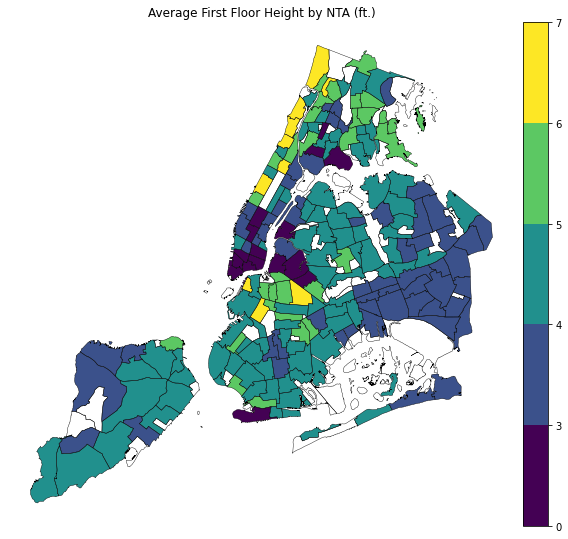

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cmap = plt.cm.viridis
norm = mpl.colors.BoundaryNorm([0, 3, 4, 5, 6, 7], cmap.N)

(nta_mean_merged
 .loc[~nta_mean_merged['nta2020'].isin(nta_exclude)]
 .plot(
    column='mean',
    legend=True,
    cmap=cmap,
    cax=cax,
    norm=norm,
    ax=ax)
)

gdf.plot(ax=ax, facecolor='None', linewidth=.4)

ax.set_title('Average First Floor Height by NTA (ft.)', fontsize=12)
ax.axis('off')
plt.tight_layout()
plt.savefig('figures/grade-floor-mean.png', dpi=250, bbox_inches='tight')

**Figure xx:** Average First Floor Height by Neighborhood Tabulation Area (NTA).

Caption this for later.

# Examining Subgrade Values

Subgrade spaces  
> As noted in the data dictionary, a subgrade space does not need to be habitable or show residential use to be recorded – this dataset cannot speak to whether recorded subgrade spaces are being used as residences. The z_grade measurement in buildings with subgrade space is not the same as the depth of the subgrade space – there is no way of knowing that measurement from outside of the building. The methodology relies on there being external clues that indicate subgrade space. It does not represent subgrade spaces that may only be internally accessible, such as cellars that may be present in large commercial or apartment buildings. **This dataset should not be treated as an inventory of subgrade spaces in New York City.**

Source: Building_Elevation_and_Subgrade_Dataset_Guidance.pdf

This dataset should not be treated as an inventory of subgrade spaces in New York City. The analysis below is purely exploratory.

Examine Notes 2 and 3.

In [65]:
df.loc[:, ['notes2', 'notes3']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847838 entries, 0 to 847837
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   notes2  188421 non-null  object
 1   notes3  472002 non-null  object
dtypes: object(2)
memory usage: 19.4+ MB


In [66]:
# notes2

with pd.option_context('display.max_colwidth', 220):

    notes2_df = (
        df
        .groupby(by='notes2')['first_floor_height']
        .mean()
        .rename('first_floor_height_avg')
        .round(2)
        .reset_index()
        .sort_values(by='first_floor_height_avg', ascending=False)
        .reset_index(drop=True)
    )
    
    display(HTML(notes2_df.to_html()))

,notes2,first_floor_height_avg
0,Attached Garage to Living Space; Partially Enclosed or Unenclosed Ground Floor for Parking or Access,7.98
1,Partially Enclosed or Unenclosed Ground Floor for Parking or Access,6.53
2,"Attached Garage to Living Space; Fully Enclosed Ground floor for Apartment Lobby, Parking, or Access (includes sites with visible flood vents)",6.11
3,"Fully Enclosed Ground floor for Apartment Lobby, Parking, or Access (includes sites with visible flood vents)",5.46
4,Attached Garage to Living Space,4.88
5,"Commercial, Industrial or other Non-Residential Lowest Floor Active Use; Partially Enclosed or Unenclosed Ground Floor for Parking or Access",4.19
6,"Commercial, Industrial or other Non-Residential Lowest Floor Active Use; Fully Enclosed Ground floor for Apartment Lobby, Parking, or Access (includes sites with visible flood vents)",2.52
7,"Commercial, Industrial or other Non-Residential Lowest Floor Active Use",1.43
8,"Commercial, Industrial or other Non-Residential Lowest Floor Active Use; Attached Garage to Living Space",0.84


**Table xx:** Mean Adjacent Grade to Floor Height by Floor Attributes (Notes 2).

Caption this for later.

In [67]:
# notes 3

with pd.option_context('display.max_colwidth', 220):
    
    notes3_df = (
        df
        .groupby(by='notes3')['first_floor_height']
        .mean()
        .rename('first_floor_height_avg')
        .round(2)
        .reset_index()
        .sort_values(by='first_floor_height_avg', ascending=False)
        .reset_index(drop=True)
    )

    display(HTML(notes3_df.to_html()))

,notes3,first_floor_height_avg
0,Visible Door or Window in subgrade space; Negative grade driveway walkway leading down to subgrade space,7.62
1,Visible Door or Window in subgrade space,4.28


**Table xx:** Mean Adjacent Grade to Floor Height by Subgrade Space Attributes (Notes 3).

Caption this for later.